In [ ]:
from iohblade import ExperimentLogger
from iohblade import plot_convergence, plot_experiment_CEG
import os

logger = ExperimentLogger('results/SBOX', True)

Failed to update token costs. Using static costs.
/home/neocortex/.cache/pypoetry/virtualenvs/blade-xXF9vABH-py3.10/lib/python3.10/site-packages/tokencost/constants.py:69: RuntimeWarning: coroutine 'update_token_costs' was never awaited
  logger.error("Failed to update token costs. Using static costs.")


In [2]:
methods, problems = logger.get_methods_problems()
print(methods)
print(problems)

['LLaMEA-codestral', 'LLaMEA-gemini-1.5-flash', 'LLaMEA-gemini-2.0-flash', 'LLaMEA-qwen2.5-coder:14b']
['SBOX_COST_fid2', 'SBOX_COST_fid5', 'SBOX_COST_fid13', 'SBOX_COST_fid15', 'SBOX_COST_fid21', 'SBOX_COST_group1', 'SBOX_COST_group2', 'SBOX_COST_group3', 'SBOX_COST_group4', 'SBOX_COST_group5']


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
# import json
# with open('results/MA_BBOB/run-LLaMEA-1-MA_BBOB-8/log.jsonl') as f:
#     for line in f:
#         print(line)
#         json.loads(line)
#test = pd.read_json(open('results/MA_BBOB/run-LLaMEA-1-MA_BBOB-8/log.jsonl', 'r', encoding='utf-8'), lines=True)

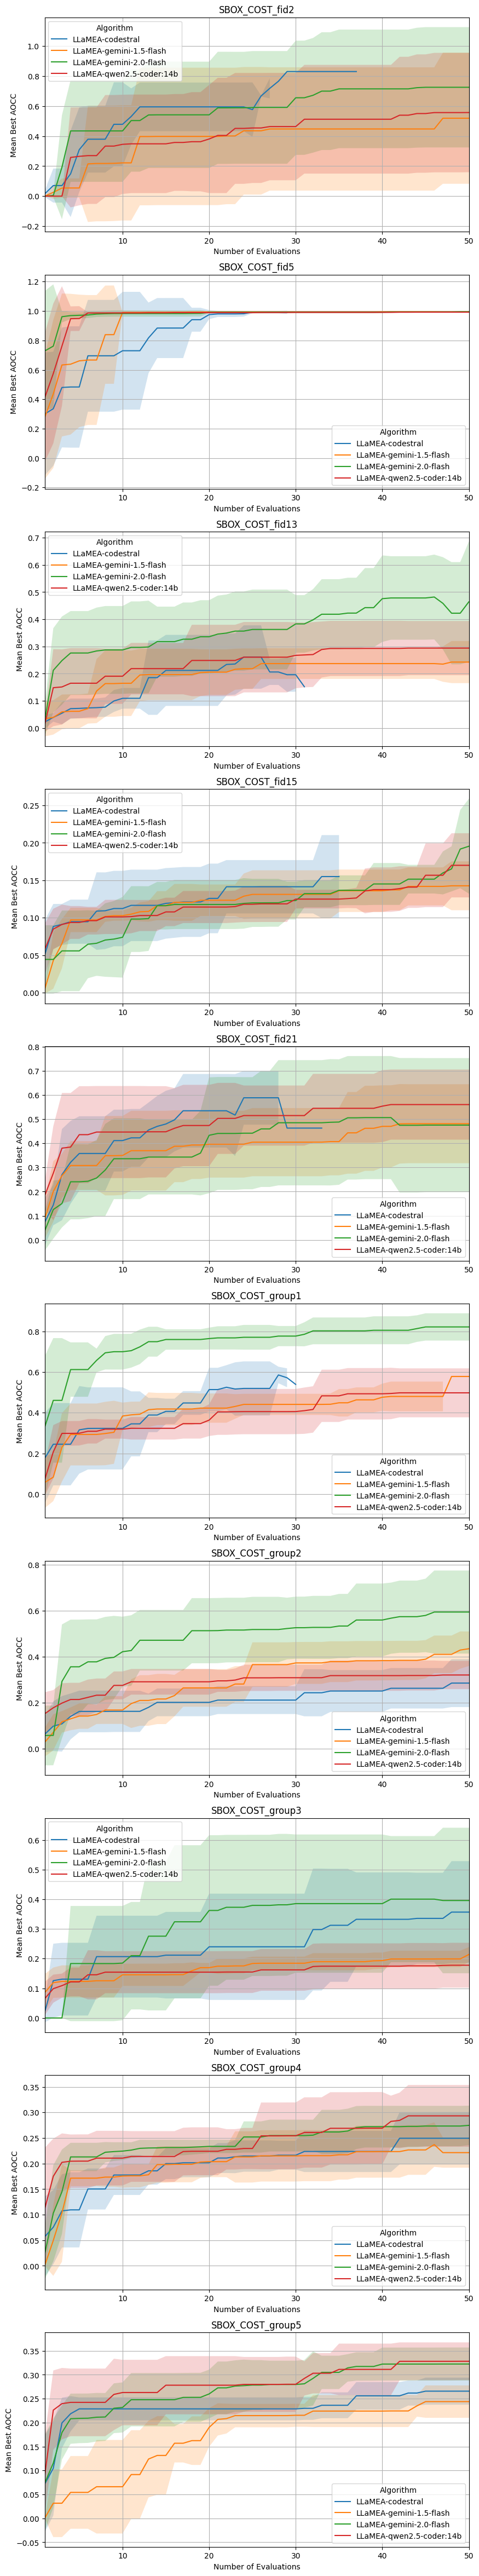

In [4]:
import numpy as np
import json


plot_convergence(logger, metric="AOCC", save=False, budget=50)



In [5]:
plot_convergence(logger, metric="AOCC", save=True, budget=50)

In [6]:
import matplotlib.pyplot as plt
from blade.plots import *



In [7]:
from scipy.stats import ttest_ind
def create_latex_table(df, alpha=0.05, smaller_is_better=False, problems=None):
    """
    Creates a LaTeX table with rows = methods, columns = problems.
    Each cell shows mean ± std (p=...).
    Cells are bolded if that method is significantly better than all others (p < alpha)
    for the given problem.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Must contain at least:
          - 'problem_name'
          - 'method_name'
          - 'solution' (dict with key 'fitness')
    alpha : float
        Significance level for p-value cutoff.
    smaller_is_better : bool
        If True, we treat lower fitness as “better.” Otherwise, higher is “better.”
    """
    # Ensure there's a 'fitness' column
    if 'fitness' not in df.columns:
        df['fitness'] = df['solution'].apply(lambda sol: sol.get('fitness', float('nan')))

    # Group data by (problem_name, method_name)
    # We'll store the runs for each combination so we can compute stats and pairwise tests
    grouped = df.groupby(['problem_name', 'method_name'])['fitness']
    stats_dict = { (p, m): grouped.get_group((p, m)).values 
                   for p, m in grouped.groups }

    if problems is None:
        problems = sorted(df['problem_name'].unique())
    methods = sorted(df['method_name'].unique())

    # Prepare a 2D structure for the table: rows=methods, cols=problems
    table_values = []

    for method in methods:
        row_entries = []
        for problem in problems:
            # Retrieve all runs for (problem, method)
            arr = stats_dict.get((problem, method), np.array([]))
            if len(arr) == 0:
                row_entries.append("N/A")
                continue

            mean_val = np.mean(arr)
            std_val = np.std(arr)
            
            # Compare this method’s distribution to each other method
            # We'll do a t-test and check p-value
            # For "significantly better than all others" we need:
            # 1) The comparison with each other method's distribution has p < alpha
            # 2) The mean is "better" (depending on smaller_is_better).
            all_better = True
            pvals = []
            for other_method in methods:
                if other_method == method:
                    continue
                other_arr = stats_dict.get((problem, other_method), np.array([]))
                if len(other_arr) == 0:
                    # If there’s no data for the other method, skip
                    continue

                # Mean comparison
                other_mean = np.mean(other_arr)
                is_better = (mean_val < other_mean) if smaller_is_better else (mean_val > other_mean)
                if not is_better:
                    all_better = False

                # Significance test
                # (We could use ttest_ind, Mann-Whitney U, etc. Here we do ttest_ind.)
                _, pval = ttest_ind(arr, other_arr, equal_var=False)
                pvals.append(pval)

            # We'll store the *maximum* p-value among all pairwise comparisons, 
            # because for the method to be "significantly better than all others",
            # *every* p-value must be below alpha.
            max_p = max(pvals) if pvals else 1.0

            cell_str = f"{mean_val:.2f} ± {std_val:.2f}"
            if all_better and (max_p < alpha):
                cell_str = "\\textbf{" + cell_str + "} "+f"(p={max_p:.3f})"
            row_entries.append(cell_str)
        table_values.append(row_entries)

    # Create a DataFrame of the final strings so we can export to LaTeX nicely
    table_df = pd.DataFrame(table_values, index=methods, columns=problems)

    return table_df

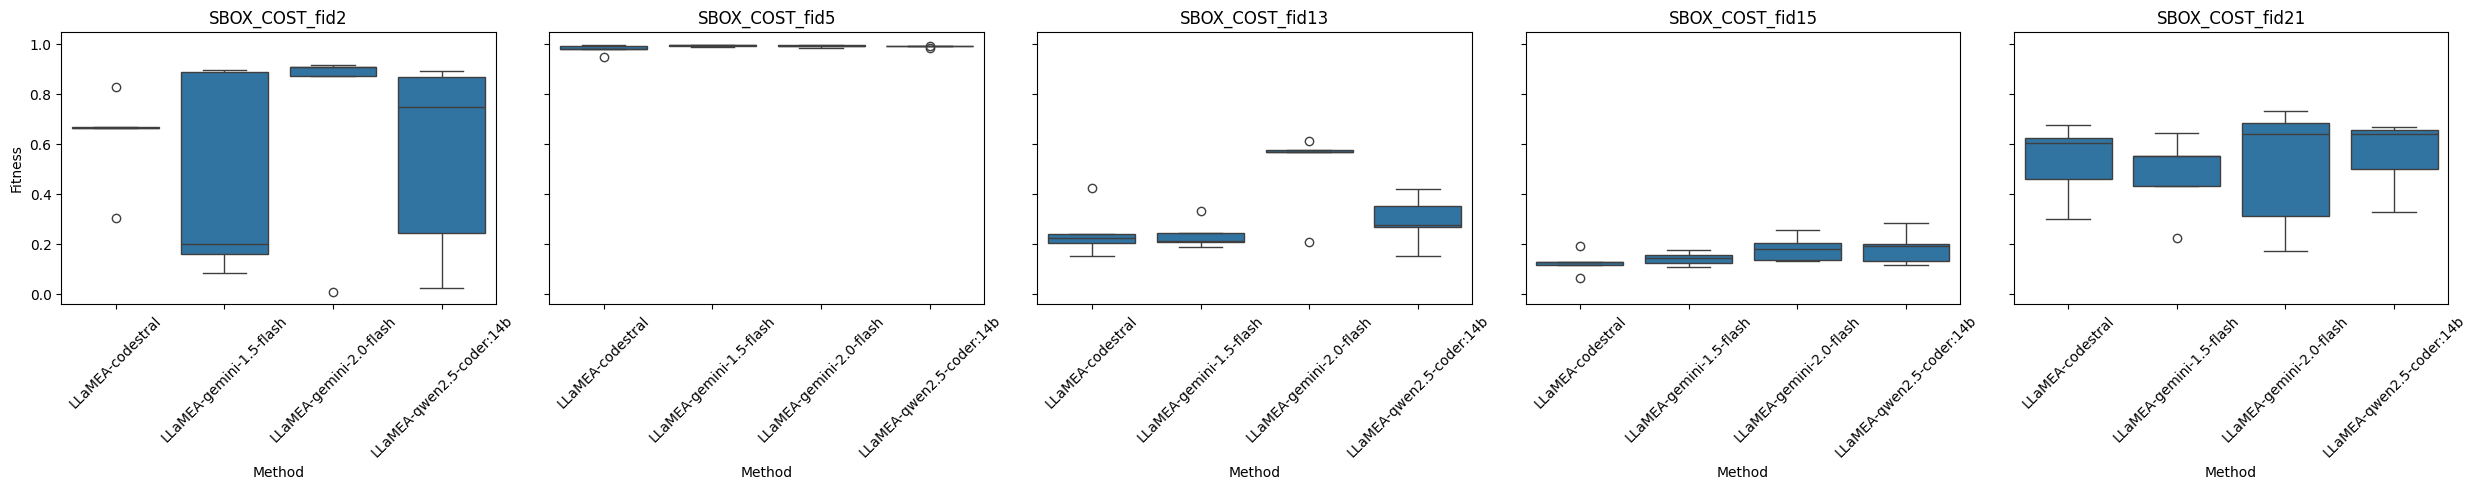

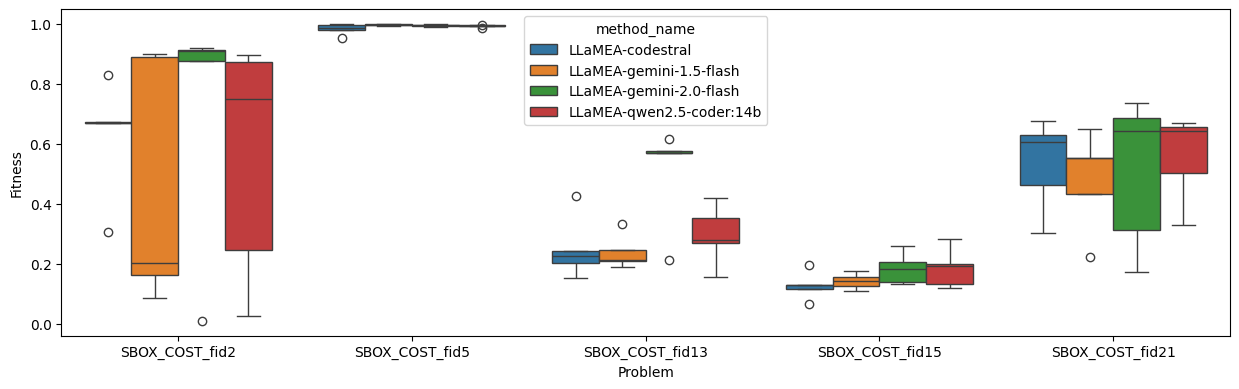

                         SBOX_COST_fid2 SBOX_COST_fid5  \
LLaMEA-codestral            0.63 ± 0.17    0.98 ± 0.02   
LLaMEA-gemini-1.5-flash     0.45 ± 0.37    1.00 ± 0.00   
LLaMEA-gemini-2.0-flash     0.72 ± 0.36    0.99 ± 0.00   
LLaMEA-qwen2.5-coder:14b    0.56 ± 0.36    0.99 ± 0.00   

                                         SBOX_COST_fid13 SBOX_COST_fid15  \
LLaMEA-codestral                             0.25 ± 0.09     0.13 ± 0.04   
LLaMEA-gemini-1.5-flash                      0.24 ± 0.05     0.14 ± 0.02   
LLaMEA-gemini-2.0-flash   \textbf{0.51 ± 0.15} (p=0.047)     0.18 ± 0.05   
LLaMEA-qwen2.5-coder:14b                     0.29 ± 0.09     0.18 ± 0.06   

                         SBOX_COST_fid21  
LLaMEA-codestral             0.53 ± 0.14  
LLaMEA-gemini-1.5-flash      0.48 ± 0.15  
LLaMEA-gemini-2.0-flash      0.51 ± 0.22  
LLaMEA-qwen2.5-coder:14b     0.56 ± 0.13  


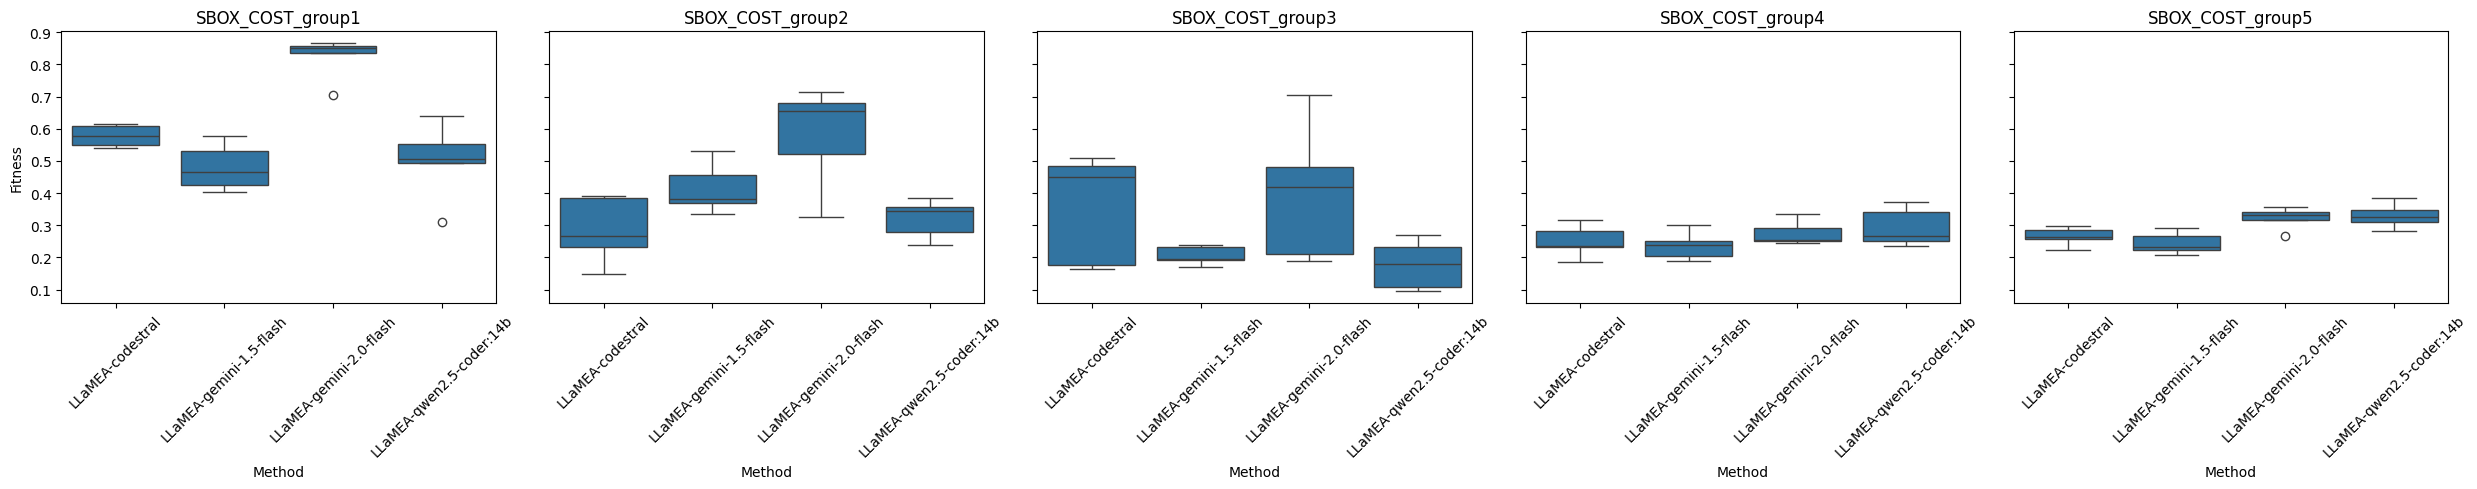

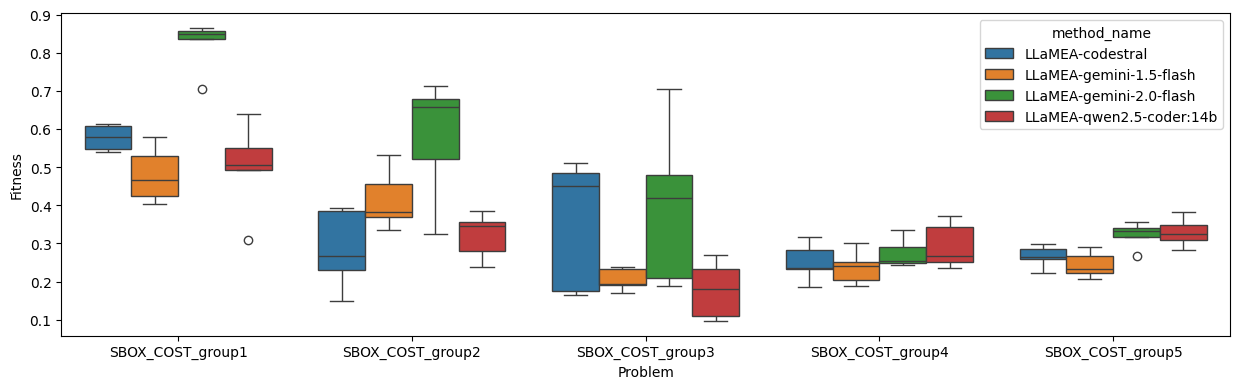

,SBOX_COST_group1,SBOX_COST_group2,SBOX_COST_group3,SBOX_COST_group4,SBOX_COST_group5
LLaMEA-codestral,0.58 ± 0.03,0.29 ± 0.09,0.36 ± 0.15,0.25 ± 0.05,0.27 ± 0.03
LLaMEA-gemini-1.5-flash,0.48 ± 0.07,0.41 ± 0.07,0.21 ± 0.03,0.24 ± 0.04,0.24 ± 0.03
LLaMEA-gemini-2.0-flash,\textbf{0.82 ± 0.06} (p=0.002),0.58 ± 0.14,0.40 ± 0.19,0.27 ± 0.03,0.32 ± 0.03
LLaMEA-qwen2.5-coder:14b,0.50 ± 0.11,0.32 ± 0.05,0.18 ± 0.07,0.29 ± 0.05,0.33 ± 0.03


In [8]:
exp_data = logger.get_data()
problems = ['SBOX_COST_fid2', 'SBOX_COST_fid5', 'SBOX_COST_fid13', 'SBOX_COST_fid15', 'SBOX_COST_fid21']
plot_boxplot_fitness(logger, problems=problems)

plot_boxplot_fitness_hue(logger, problems=problems)

table_df = create_latex_table(exp_data, alpha=0.05, problems=problems)
print(table_df)
latex_str = table_df.to_latex(escape=False)
with open('sbox-table1.tex', 'w', encoding='utf-8') as f:
    f.write(latex_str)

problems = ['SBOX_COST_group1', 'SBOX_COST_group2', 'SBOX_COST_group3', 'SBOX_COST_group4', 'SBOX_COST_group5']
plot_boxplot_fitness(logger, problems=problems)
plot_boxplot_fitness_hue(logger, problems=problems)

table_df = create_latex_table(exp_data, alpha=0.05, problems=problems)
latex_str = table_df.to_latex(escape=False)
with open('sbox-table2.tex', 'w', encoding='utf-8') as f:
    f.write(latex_str)
table_df
# Convert to LaTeX; escape=False so we can keep the \textbf{} markup
#latex_str = table_df.to_latex(escape=False)
#TODO get all final solutions and benchmark them using IOH.